# Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping

from keras.applications import EfficientNetB0

# Create a datasets
We use <a href="https://www.kaggle.com/datasets/datahmifitb/felis-taxonomy-image-classification/data">Felis Taxonomy Image Classification dataset</a> from Kaggle

In [ ]:
# Data directories
data_dir = "./data"

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

In [ ]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 519 files belonging to 7 classes.
Using 416 files for training.


In [ ]:
ds_test = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 519 files belonging to 7 classes.
Using 103 files for validation.


In [ ]:
class_names = ds_train.class_names
NUM_CLASSES = len(class_names)

print("#Classes:", NUM_CLASSES)
print(class_names)

#Classes: 7
['african-wildcat', 'blackfoot-cat', 'chinese-mountain-cat', 'domestic-cat', 'european-wildcat', 'jungle-cat', 'sand-cat']


## Visualize the data

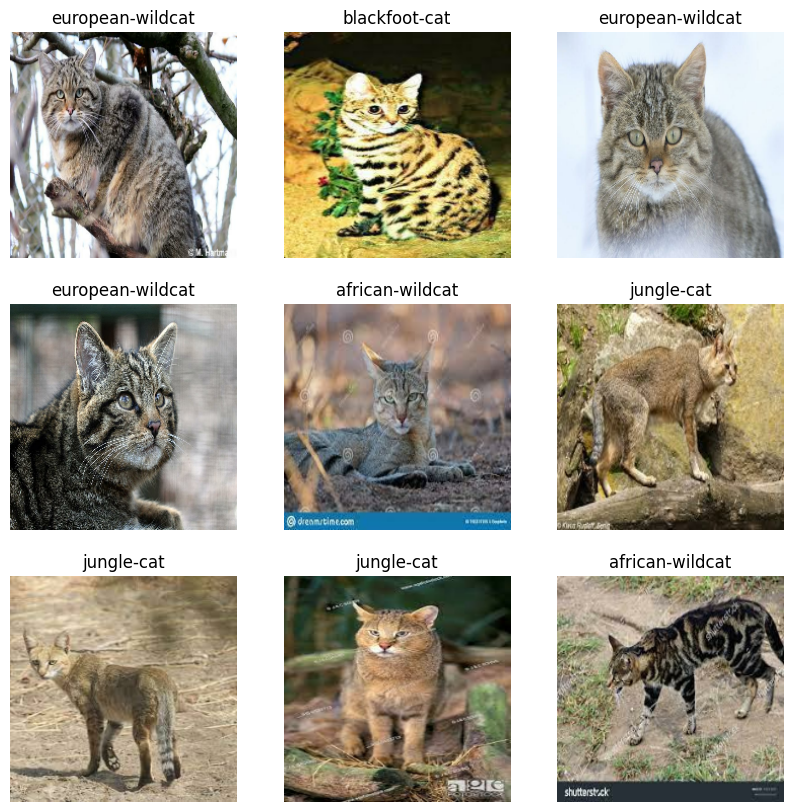

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Create model

In [ ]:
# Augmentation layers
img_augmentation_layers = Sequential([
    layers.RandomRotation(factor=0.15, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = img_augmentation_layers(inputs)

    base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    # Freeze the pretrained weights
    base_model.trainable = False
    x = base_model(x)

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=3e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )
    return model

model = build_model(num_classes=NUM_CLASSES)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ top_dropout (Dropout)                │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pred (Dense)                         │ (None, 7)                   │           8,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,063,658 (15.50 MB)

 Trainable params: 11,527 (45.03 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

# Train model

In [ ]:
epochs = 128

# early stopping
early_stop_cb = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=10,
    restore_best_weights=True
)

In [ ]:
hist = model.fit(ds_train, epochs=epochs,
                 validation_data=ds_test,
                 callbacks=[early_stop_cb])

Epoch 1/128
26/26 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.1819 - loss: 2.5695 - val_accuracy: 0.3010 - val_loss: 1.8165
Epoch 2/128
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.2976 - loss: 1.8640 - val_accuracy: 0.4563 - val_loss: 1.6448
Epoch 3/128
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.3863 - loss: 1.8120 - val_accuracy: 0.5534 - val_loss: 1.5111
Epoch 4/128
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.4836 - loss: 1.4274 - val_accuracy: 0.5922 - val_loss: 1.3869
Epoch 5/128
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.5716 - loss: 1.2226 - val_accuracy: 0.6505 - val_loss: 1.2846
Epoch 6/128
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5694 - loss: 1.2027 - val_accuracy: 0.6699 - val_loss: 1.1904
Epoch 7/128
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.6001 - loss: 1.1354 - val_accuracy: 0.6990 - val_loss: 1.1053
Epoch 8/128
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.6106 - loss: 1.1806 - val_accuracy: 

# Evaluate model

In [ ]:
loss_df = pd.DataFrame(hist.history)
loss_df

,accuracy,loss,val_accuracy,val_loss
0,0.194712,2.472225,0.300971,1.816470
1,0.336538,1.853782,0.456311,1.644845
2,0.406250,1.706967,0.553398,1.511082
3,0.487981,1.442018,0.592233,1.386880
4,0.536058,1.295855,0.650485,1.284614
...,...,...,...,...
57,0.860577,0.451818,0.844660,0.596881
58,0.850962,0.440961,0.834951,0.593521
59,0.855769,0.431883,0.864078,0.591562
60,0.872596,0.401962,0.854369,0.592015


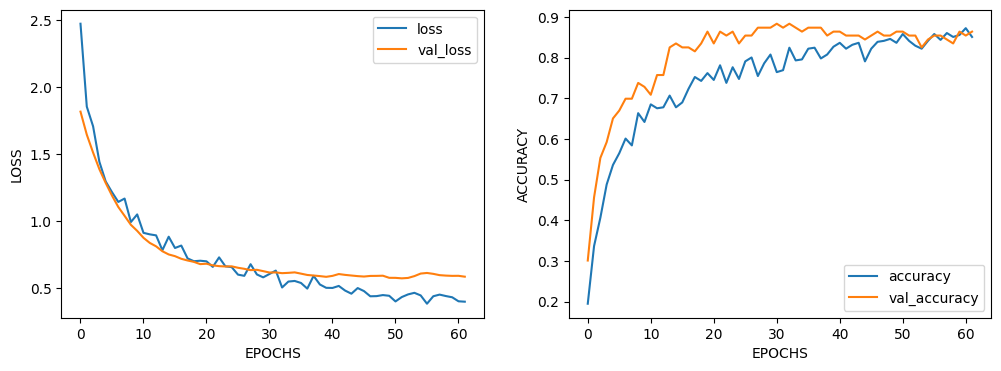

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_df["loss"], label="loss")
plt.plot(loss_df["val_loss"], label="val_loss")
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_df["accuracy"], label="accuracy")
plt.plot(loss_df["val_accuracy"], label="val_accuracy")
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.legend()

In [ ]:
scores = model.evaluate(ds_test)
scores

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8469 - loss: 0.5937


[0.5731155872344971, 0.8543689250946045]

# Save model

In [ ]:
# Save final model
# model.save("models/felis_taxonomy_efficientnet.keras")

# Load final model
loaded_model = load_model("models/felis_taxonomy_efficientnet.keras")

In [ ]:
# Get predictions on test data
y_pred = loaded_model.predict(ds_test)

predictions = [np.argmax(tf.nn.softmax(x)) for x in y_pred]
print(predictions)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 374ms/step
[1, 0, 1, 5, 5, 6, 4, 4, 6, 3, 1, 6, 1, 1, 1, 0, 5, 3, 2, 6, 1, 1, 3, 0, 2, 0, 3, 0, 6, 4, 0, 6, 6, 4, 1, 6, 6, 3, 1, 4, 5, 5, 3, 6, 5, 4, 0, 4, 5, 6, 3, 0, 0, 5, 5, 2, 4, 5, 5, 4, 4, 6, 0, 1, 2, 0, 4, 3, 2, 6, 6, 4, 4, 4, 0, 4, 1, 1, 3, 5, 4, 5, 4, 6, 4, 3, 0, 2, 3, 4, 4, 4, 4, 4, 0, 0, 6, 1, 6, 4, 4, 6, 3]


# Prediction on new data

In [ ]:
# Prepare image for predictions
def prepare_image(path_to_img, target_size=IMG_SIZE):
    img = tf.keras.utils.load_img(path_to_img, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    return img_array

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Prediction:  african-wildcat


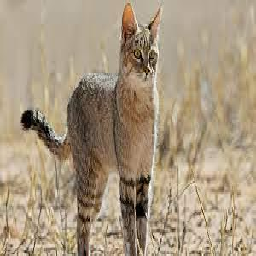

In [ ]:
image_path = "data/african-wildcat/af (48).jpg"

# Predict on new data
prep_img = prepare_image(image_path)
pred = loaded_model.predict(prep_img)
score = tf.nn.softmax(pred[0])
print("Prediction: ", class_names[np.argmax(score)])

# for image visualization
image = tf.keras.utils.load_img(image_path, target_size=(256, 256))
image